In [1]:
import torch
import torch.nn as nn

import igconv

from basicsr.models import build_model
from basicsr.utils.options import yaml_load


from einops import rearrange

import matplotlib.pyplot as plt

# disable gradient computation
torch.set_grad_enabled(False)

/home/dslisleedh/miniconda3/envs/igconv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
opt = "/home/dslisleedh/IGConv/options/test/RDN/RDNIGPlus_DIV2K.yaml"
opt = yaml_load(opt)

opt['is_train'] = False
opt['dist'] = False

model = build_model(opt)

In [3]:
model.net_g.state_dict().keys()

odict_keys(['SFENet1.weight', 'SFENet1.bias', 'SFENet2.weight', 'SFENet2.bias', 'RDBs.0.convs.0.conv.0.weight', 'RDBs.0.convs.0.conv.0.bias', 'RDBs.0.convs.1.conv.0.weight', 'RDBs.0.convs.1.conv.0.bias', 'RDBs.0.convs.2.conv.0.weight', 'RDBs.0.convs.2.conv.0.bias', 'RDBs.0.convs.3.conv.0.weight', 'RDBs.0.convs.3.conv.0.bias', 'RDBs.0.convs.4.conv.0.weight', 'RDBs.0.convs.4.conv.0.bias', 'RDBs.0.convs.5.conv.0.weight', 'RDBs.0.convs.5.conv.0.bias', 'RDBs.0.convs.6.conv.0.weight', 'RDBs.0.convs.6.conv.0.bias', 'RDBs.0.convs.7.conv.0.weight', 'RDBs.0.convs.7.conv.0.bias', 'RDBs.0.LFF.weight', 'RDBs.0.LFF.bias', 'RDBs.1.convs.0.conv.0.weight', 'RDBs.1.convs.0.conv.0.bias', 'RDBs.1.convs.1.conv.0.weight', 'RDBs.1.convs.1.conv.0.bias', 'RDBs.1.convs.2.conv.0.weight', 'RDBs.1.convs.2.conv.0.bias', 'RDBs.1.convs.3.conv.0.weight', 'RDBs.1.convs.3.conv.0.bias', 'RDBs.1.convs.4.conv.0.weight', 'RDBs.1.convs.4.conv.0.bias', 'RDBs.1.convs.5.conv.0.weight', 'RDBs.1.convs.5.conv.0.bias', 'RDBs.1.conv

In [25]:
def reshape_kernel(kernel, scale: int):
    kernel = rearrange(kernel, '(c_out rh rw) c_in kh kw -> c_out c_in rh rw kh kw', c_out=3, rh=scale, rw=scale)
    return kernel

res_dict = {}    
res_dict_ruma = {}
scale = 32

for scale in [2, 3, 4, 32]:
    with torch.cuda.amp.autocast():   # scale 32 raises OOM
        with torch.no_grad():
            model.net_g.cpu()
            
            k = model.net_g.UPNet.resize(scale)
            
            c = k.shape[0]
            
            k_hflip = k.flip([3])
            k_vflip = k.flip([2])
            k_hvflip = k.flip([2, 3])
            k_rot90 = torch.rot90(k, -1, [2, 3])
            k_rot90_hflip = k_rot90.flip([3])
            k_rot90_vflip = k_rot90.flip([2])
            k_rot90_hvflip = k_rot90.flip([2, 3])
            k = torch.cat([k, k_hflip, k_vflip, k_hvflip, k_rot90, k_rot90_hflip, k_rot90_vflip, k_rot90_hvflip], dim=0)
            I = torch.eye(c).to(k.device).reshape(c, c) / 8.
            I = I.repeat(1, 8)
            k = torch.einsum('oihw,jo -> jihw', k, I)

            k = reshape_kernel(k, scale)
            k_center = torch.mean(k, dim=(4, 5))  # reduce kh and kw
            
            k_gray = 0.2126 * k_center[:1] + 0.7152 * k_center[1:2] + 0.0722 * k_center[2:3]
            
    res_dict[str(scale)] = k_gray.permute(1, 2, 3, 0).cpu().numpy()
    
    print(scale, k_gray.shape)

2 torch.Size([1, 64, 2, 2])
3 torch.Size([1, 64, 3, 3])
4 torch.Size([1, 64, 4, 4])
32 torch.Size([1, 64, 32, 32])


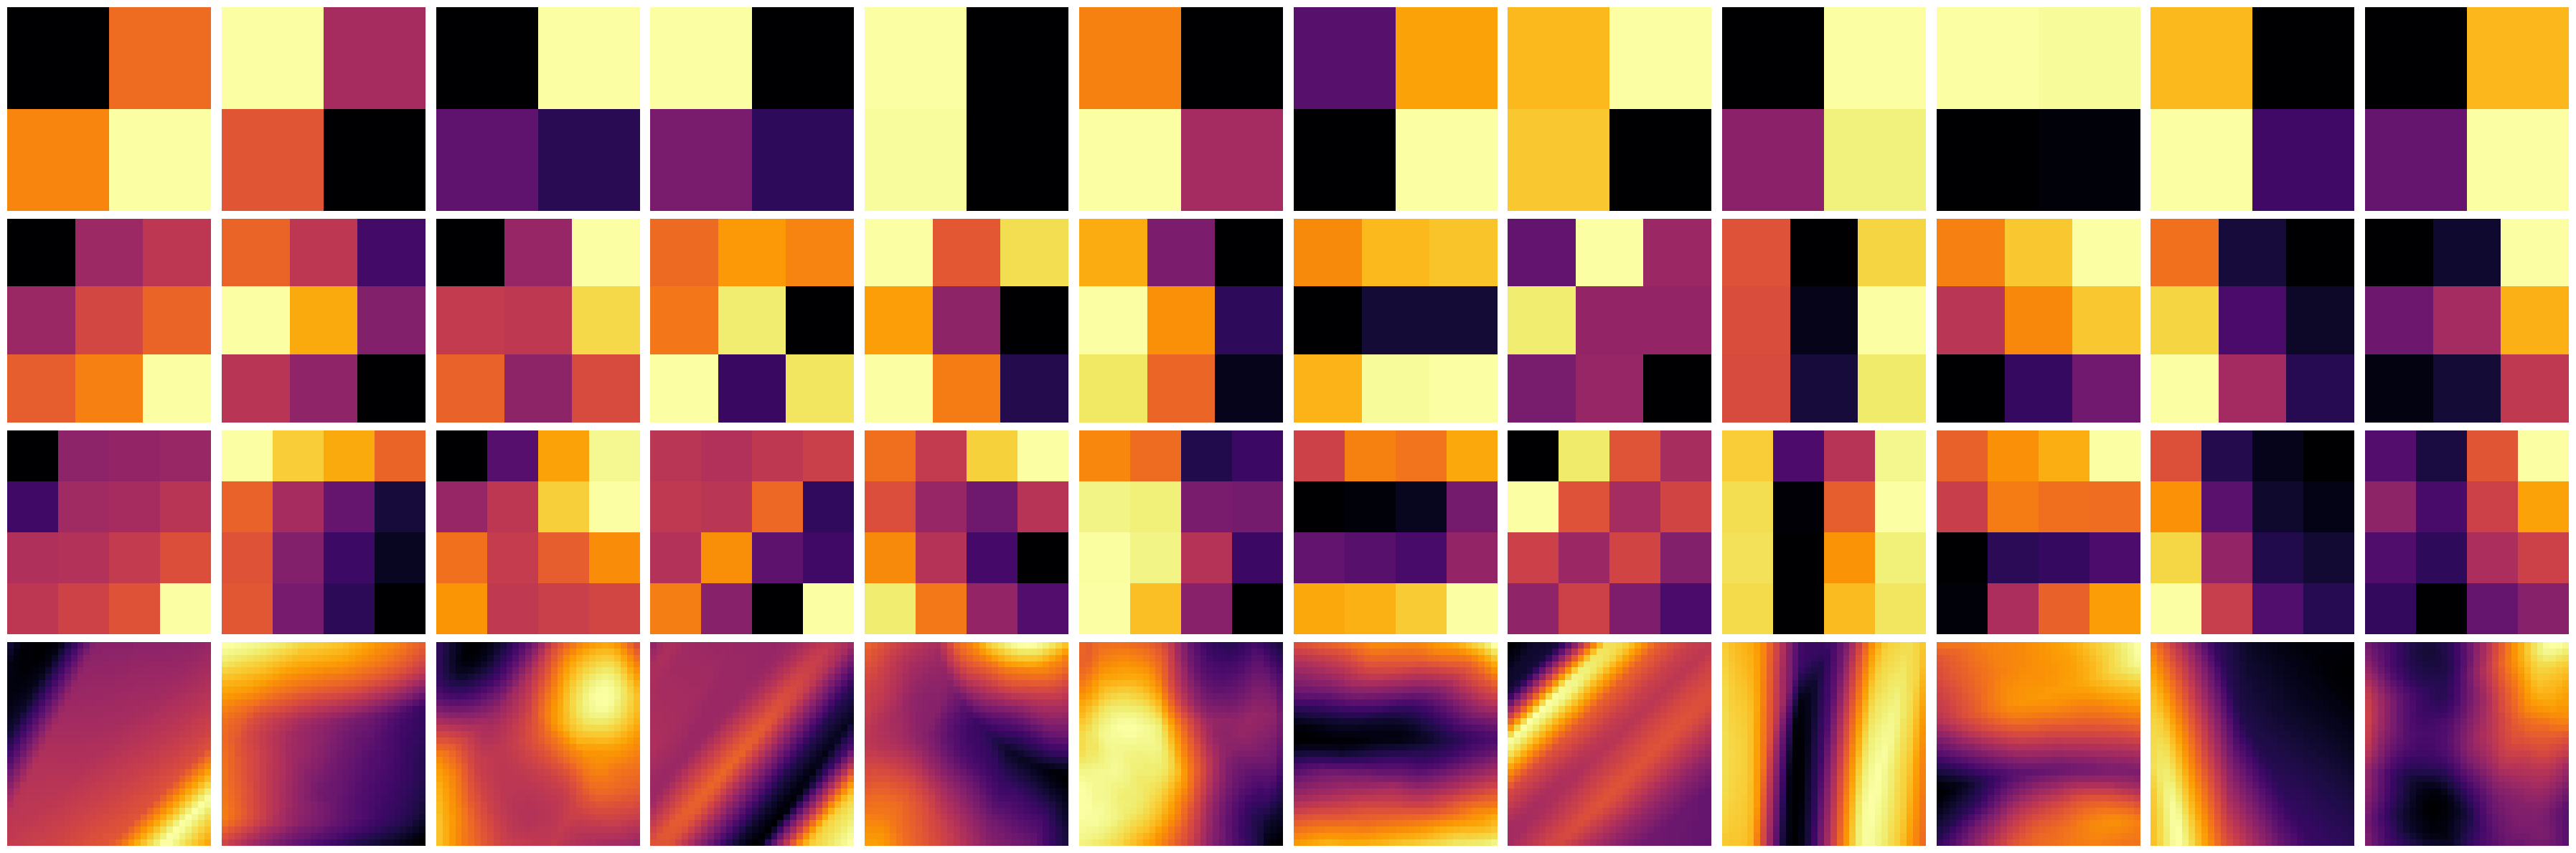

In [26]:
n_vis = 12
res_mult = 3

fig, axes = plt.subplots(4, n_vis, figsize=(n_vis * res_mult, 4 * res_mult))

for i in range(n_vis):
    for j, s in enumerate([2, 3, 4, 32]):
        axes[j, i].imshow(res_dict[str(s)][i, ...], cmap='inferno')
        axes[j, i].axis('off')

plt.tight_layout()
plt.show()

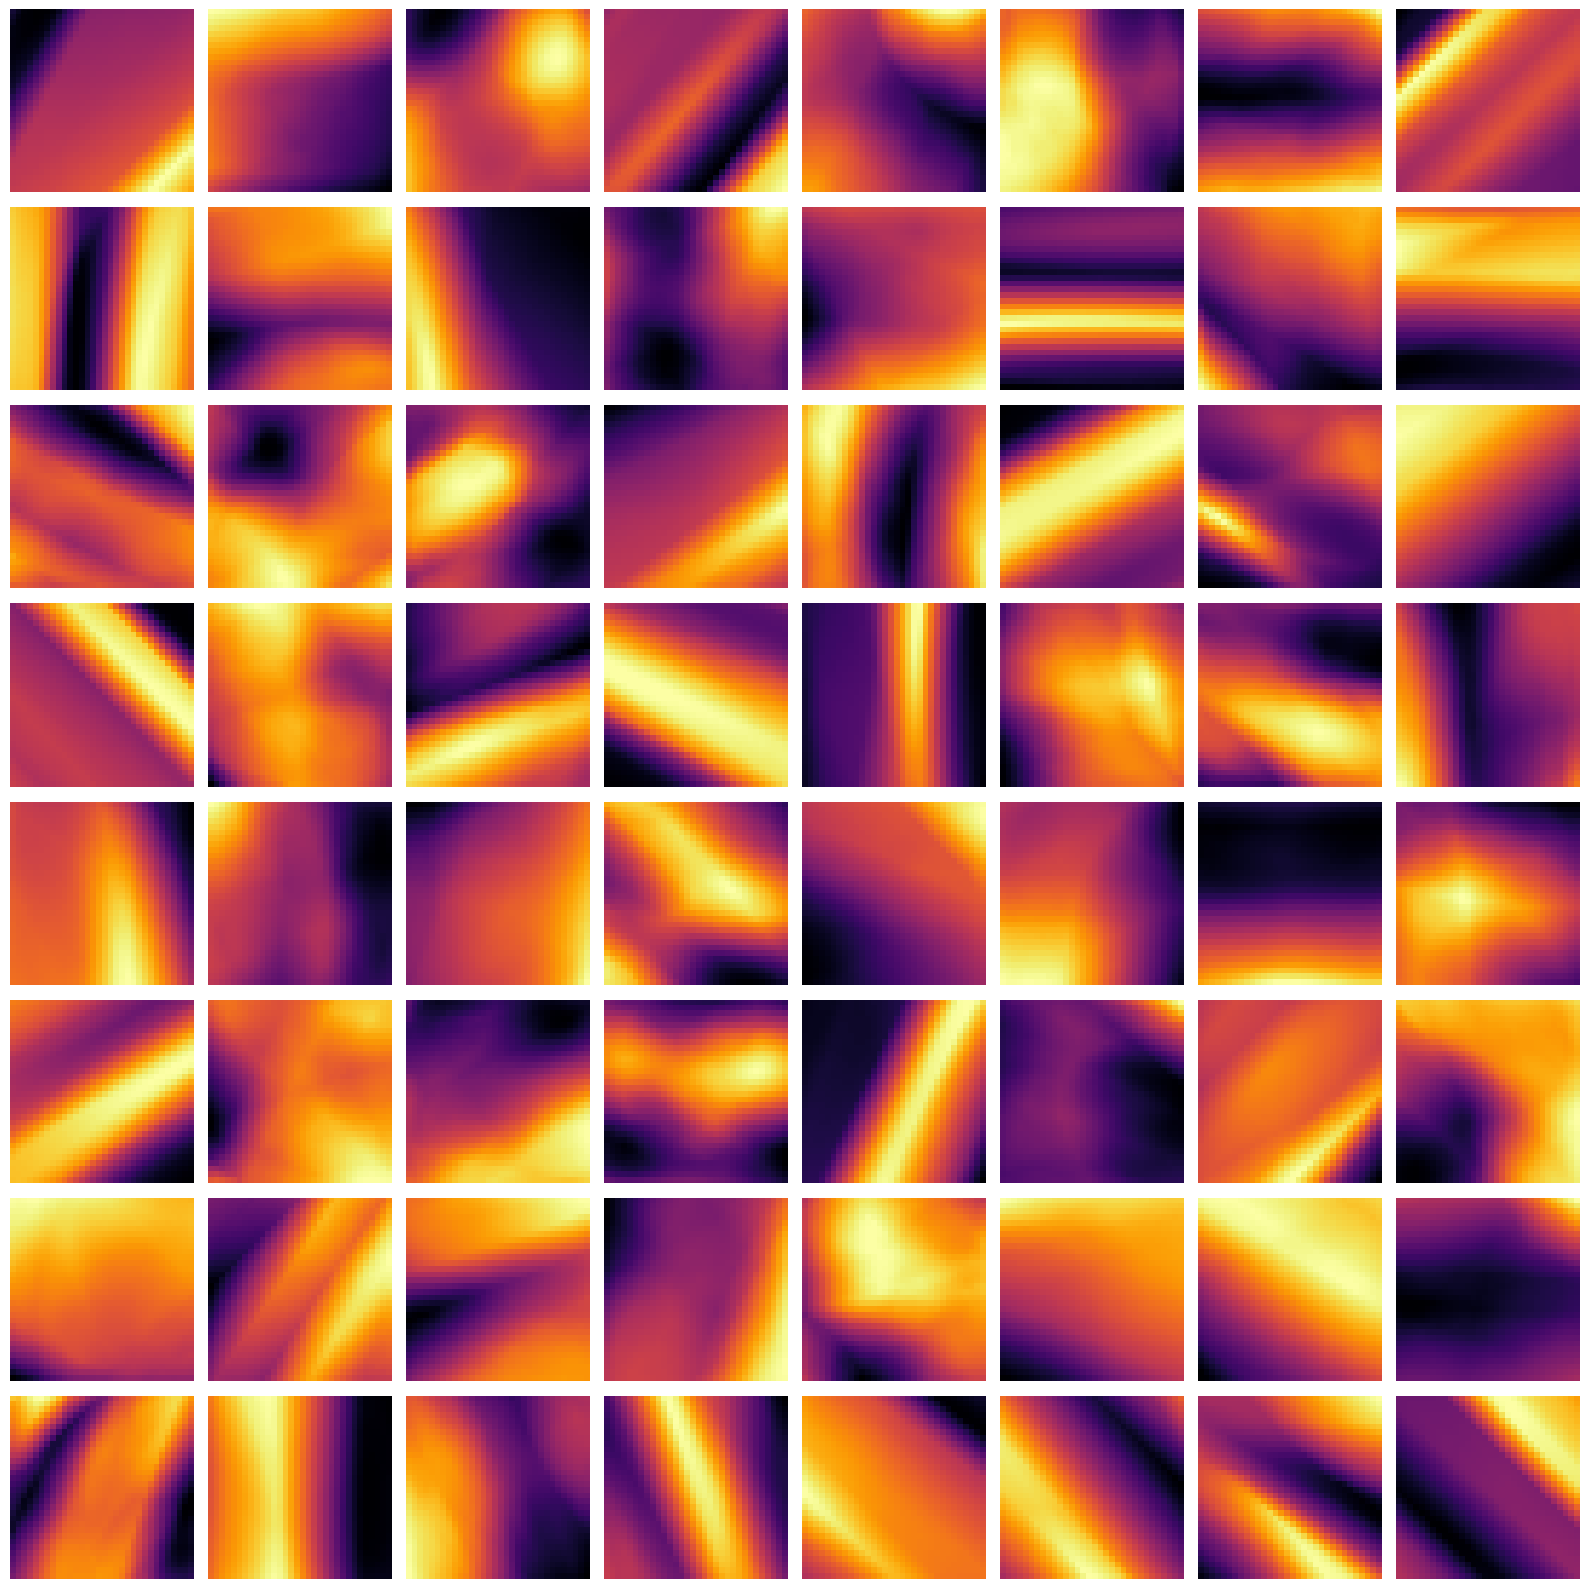

In [25]:
fig, ax = plt.subplots(8, 8, figsize=(16, 16))

k_center = 0.2126 * k_center[0] + 0.7152 * k_center[1] + 0.0722 * k_center[2]  # RGB to Gray
k_center = k_center.unsqueeze(0)

for i in range(8):
    for j in range(8):
        # ax[i, j].imshow(k_center[:, i*8+j].detach().permute(1, 2, 0).float().cpu().numpy())
        cur_k = k_center[:, i*8+j].detach().permute(1, 2, 0).float().cpu().numpy()
        # minmax normalization
        cur_k = (cur_k - cur_k.min()) / (cur_k.max() - cur_k.min())
        ax[i, j].imshow(cur_k, cmap='inferno')
        ax[i, j].axis('off')

plt.tight_layout()